# Setup guide

In [2]:
# Standard Library Imports
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
from pathlib import Path
import os
import random
from io import StringIO
import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
#import ee
#import geemap

#from lightgbm import LGBMClassifier
#from shapely.affinity import scale, translate
#from skimage import exposure
#from sklearn.metrics import classification_report, f1_score
#from sklearn.model_selection import StratifiedKFold, train_test_split
#from sklearn.preprocessing import LabelEncoder

import rasterio
from shapely import wkt
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

import logging

## Download & Read file

In [7]:
# Read train & test file
train_csv = "https://api.zindi.africa/v1/competitions/telangana-crop-health-challenge/files/Train.csv?auth_token=zus.v1.r9SLXZb.BjkGgVGb5BPeUq9JbM7Sjx7meYQ6t7"
test_csv = "https://api.zindi.africa/v1/competitions/telangana-crop-health-challenge/files/Test.csv?auth_token=zus.v1.r9SLXZb.BjkGgVGb5BPeUq9JbM7Sjx7meYQ6t7"

In [9]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7888 entries, 0 to 7887
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   FarmID           7888 non-null   int64 
 1   category         7888 non-null   object
 2   Crop             7888 non-null   object
 3   State            7888 non-null   object
 4   District         7888 non-null   object
 5   Sub-District     7888 non-null   object
 6   SDate            7888 non-null   object
 7   HDate            7888 non-null   object
 8   CropCoveredArea  7888 non-null   int64 
 9   CHeight          7888 non-null   int64 
 10  CNext            7888 non-null   object
 11  CLast            7888 non-null   object
 12  CTransp          7888 non-null   object
 13  IrriType         7888 non-null   object
 14  IrriSource       7888 non-null   object
 15  IrriCount        7888 non-null   int64 
 16  WaterCov         7888 non-null   int64 
 17  ExpYield         7888 non-null   

In [10]:
# Convert WKT geometry to actual geometry objects in both datasets
train_df['geometry'] = train_df['geometry'].apply(wkt.loads)
test_df['geometry'] = test_df['geometry'].apply(wkt.loads)
# Convert pandas DataFrames to GeoDataFrames with CRS set to 'epsg:4326'
train = gpd.GeoDataFrame(train_df, crs='epsg:4326')
test = gpd.GeoDataFrame(test_df, crs='epsg:4326')

In [11]:
data = pd.concat(
    [train.assign(dataset='train'), test.assign(dataset='test')]
).reset_index(drop=True)

In [12]:
data.head()

,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,CHeight,...,CLast,CTransp,IrriType,IrriSource,IrriCount,WaterCov,ExpYield,Season,geometry,dataset
0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,54,...,Lentil,Transplanting,Flood,Groundwater,4,87,17,Rabi,"POLYGON ((78.18143 17.97888, 78.18149 17.97899...",train
1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,58,...,Lentil,Transplanting,Flood,Canal,5,94,15,Rabi,"POLYGON ((78.17545 17.98107, 78.17578 17.98104...",train
2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,91,...,Lentil,Transplanting,Flood,Canal,3,99,20,Rabi,"POLYGON ((78.16914 17.97621, 78.1693 17.97619,...",train
3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,52,...,Lentil,Transplanting,Flood,Canal,5,92,16,Rabi,"POLYGON ((78.16889 17.97461, 78.16916 17.97471...",train
4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,55,...,Lentil,Transplanting,Flood,Canal,5,97,20,Rabi,"POLYGON ((78.17264 17.96925, 78.17276 17.96926...",train


In [13]:
from shapely.affinity import scale, translate
# Function to scale each geometry around its centroid
def scale_geometry(geometry, scale_factor):
    """
    Scale a geometry object around its centroid.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): Geometry to scale.
        scale_factor (float): Factor by which to scale the geometry.

    Returns:
        shapely.geometry.base.BaseGeometry: Scaled geometry object.
    """
    # Calculate centroid
    centroid = geometry.centroid
    # Translate geometry to origin
    translated_geometry = translate(geometry, -centroid.x, -centroid.y)
    # Scale geometry
    scaled_geometry = scale(translated_geometry, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))
    # Translate back to the original centroid
    return translate(scaled_geometry, centroid.x, centroid.y)

In [19]:
data['geometry'] = data['geometry'].apply(scale_geometry, scale_factor=5)

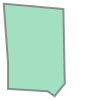

In [21]:
data['geometry'][5]

In [25]:
import ee
ee.Initialize()
ee.Geometry.Polygon(data['geometry'][5].__geo_interface__['coordinates'])

EEException: Please authorize access to your Earth Engine account by running

earthengine authenticate

in your command line, or ee.Authenticate() in Python, and then retry.

In [193]:
bbox_coords = data.iloc[15:16].total_bounds

In [195]:
bbox_coords, data.iloc[0:1+1].total_bounds

(array([78.14990264, 17.81341205, 78.15184713, 17.81413346]),
 array([78.18079255, 17.97819175, 78.18240015, 17.97948076]))

In [173]:
import pystac_client
from datetime import datetime
import planetary_computer

# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"

# You can query a STAC API endpoint from Python using the pystac_client library:
stac_client = pystac_client.Client.open(aws_stac_url)

In [175]:
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"], # Sentinel-2, Level 2A, Cloud Optimized GeoTiffs (COGs)
    bbox=list(bbox_coords),
    datetime="2023-11-25/2024-04-14", 
    query={"eo:cloud_cover": {"lt": 25}, "s2:nodata_pixel_percentage": {"lt": 25}}, 
)

In [177]:
# Retrieve all items (still just metadata) from search results
s2_items = s2_search.item_collection()

In [178]:
s2_items[0].properties

{'created': '2024-04-07T13:49:32.288Z',
 'platform': 'sentinel-2a',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 5.087475,
 'proj:epsg': 32643,
 'mgrs:utm_zone': 43,
 'mgrs:latitude_band': 'Q',
 'mgrs:grid_square': 'HV',
 'grid:code': 'MGRS-43QHV',
 'view:sun_azimuth': 114.439264234379,
 'view:sun_elevation': 66.8248066808714,
 's2:degraded_msi_data_percentage': 0.0106,
 's2:nodata_pixel_percentage': 2.642553,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 0.002842,
 's2:cloud_shadow_percentage': 0.268276,
 's2:vegetation_percentage': 12.946469,
 's2:not_vegetated_percentage': 78.977424,
 's2:water_percentage': 1.777384,
 's2:unclassified_percentage': 0.940129,
 's2:medium_proba_clouds_percentage': 2.58695,
 's2:high_proba_clouds_percentage': 0.995347,
 's2:thin_cirrus_percentage': 1.505178,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '05.10',
 's2:product_uri': 'S2A_MSIL2A_202404

In [179]:
import rioxarray
nir_href = s2_items[0].assets['nir'].href
nir_s = rioxarray.open_rasterio(nir_href)

In [180]:
print(nir_s)

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 8e+05 8e+05 8e+05 ... 9.098e+05 9.098e+05
  * y            (y) float64 88kB 2e+06 2e+06 2e+06 ... 1.89e+06 1.89e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


In [185]:
nir_s.values

array([[[   0,    0,    0, ..., 2974, 2840, 2844],
        [   0,    0,    0, ..., 2946, 2934, 2864],
        [   0,    0,    0, ..., 2968, 2972, 2908],
        ...,
        [3752, 3736, 3456, ..., 1698, 1708, 1798],
        [3836, 3852, 3476, ..., 1670, 1730, 1888],
        [3752, 3692, 3440, ..., 1636, 1796, 1840]]],
      shape=(1, 10980, 10980), dtype=uint16)

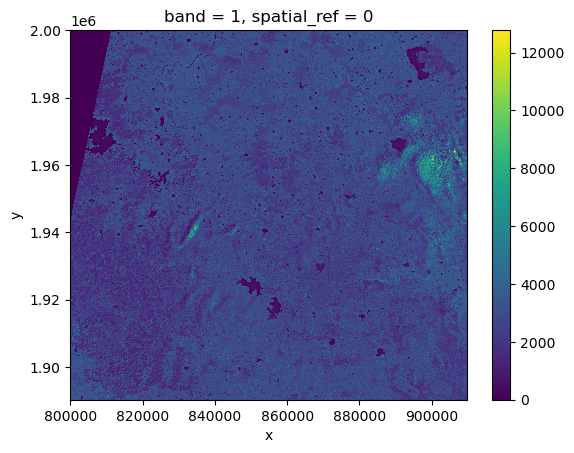

In [186]:
nir_s.plot()

In [3]:
import os 

In [7]:
os.listdir()

['.DS_Store',
 'Setup.ipynb',
 '.gitkeep',
 'TCD001.ipynb',
 'test_dir',
 'gee_downloads',
 '.ipynb_checkpoints']

In [40]:
len(os.listdir('gee_downloads'))

6784